In [14]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from pathlib import Path
from IPython import display

import torch
import pandas as pd
import numpy as np
from progiter import ProgIter

from src.prev.calibration import CalibrationMethod, calibrate_logits_fast, missmatch_priors
from src.prev.scaling import scale_prevalences_ir
from src.prev.plotting import plot_aggregate_results, Confidence, box_plot, multiplot
from src.prev.thresholding import find_best_thresholds
from src.prev.utils import Metric, ThresholdingMethod, compute_all_metrics, last_value_df
from src.prev.data_loading import get_values, Kind, Split

import torch.nn.functional as F

current_path = os.getcwd()
DATA_PATH = Path(current_path).parent/ 'data'
RESULT_PATH = Path(current_path).parent/ 'results'
assert DATA_PATH.exists() and RESULT_PATH.exists()
torch.manual_seed(seed=0)

In [2]:
all_tasks = ['lapgyn4_surgical_actions', 'lapgyn4_instrument_count', 'lapgyn4_anatomical_actions', 'nerthus_bowel_cleansing_quality', 'hyperkvasir_therapeutic-interventions', 'cholec80_grasper_presence', 'cholec80_hook_presence', 'idle_action_recognition', 'brain_tumor_classification', 'brain_tumor_type_classification', 'chexpert_enlarged_cardiomediastinum', 'chexpert_cardiomegaly', 'chexpert_edema', 'chexpert_consolidation', 'chexpert_pneumonia', 'chexpert_pneumothorax', 'chexpert_pleural_effusion', 'chexpert_fracture', 'pneumonia_classification', 'covid_xray_classification', 'deep_drid_dr_level', 'deep_drid_quality', 'kvasir_capsule_anatomy', 'mura_xr_wrist', 'mura_xr_shoulder', 'mura_xr_humerus', 'mura_xr_hand', 'mura_xr_forearm', 'mura_xr_finger', 'mura_xr_elbow']
binary_tasks = ['hyperkvasir_therapeutic-interventions', 'cholec80_grasper_presence', 'cholec80_hook_presence', 'idle_action_recognition', 'brain_tumor_classification', 'chexpert_enlarged_cardiomediastinum', 'chexpert_cardiomegaly', 'chexpert_edema', 'chexpert_consolidation', 'chexpert_pneumonia', 'chexpert_pneumothorax', 'chexpert_pleural_effusion', 'chexpert_fracture', 'pneumonia_classification', 'covid_xray_classification', 'deep_drid_quality', 'kvasir_capsule_anatomy', 'mura_xr_wrist', 'mura_xr_shoulder', 'mura_xr_humerus', 'mura_xr_hand', 'mura_xr_forearm', 'mura_xr_finger', 'mura_xr_elbow']
data = {}
for t in ProgIter(all_tasks, desc='Loading data'):
    data[t] = get_values(t, DATA_PATH, proj='mic23_predictions_original_0')  # original paper predictions
    # data[t] = get_values(t, DATA_PATH, proj='mic23_predictions_reproduce_0')  # additional seed experiment

Loading data 100.00% 30/30... rate=4.37 Hz, eta=0:00:00, total=0:00:06


In [3]:
def thresholds_accross_ir(task_data, step=0.5, calibration: CalibrationMethod = CalibrationMethod.NONE,
                          thresholding: ThresholdingMethod=ThresholdingMethod.ARGMAX, std=None):
    """
    Computes the values of metrics for optimal thresholds computed for the application test set and
    thresholds set on the development test set for a given task across imbalance ratios.

    :param task_data:
    :param step: step size for varying the imbalance ratio
    :param calibration: calibration method
    :param thresholding: thresholding method to be used
    :param std: for estimating prevalence for scaling and threshold computation, defaults to None
    :return results: dictionary of metric values
    """                  
    # intiialize the results dictionary
    results ={m: [] for m in Metric}
    results.update(zip(["reference "+m.value for m in Metric], [[] for m in Metric]))
    # define the imbalance ratio range
    ir_range = np.arange(1, 10+step, step)
    for ir in ir_range:
        # scale prevalences in the deployment set according to imbalance ratio
        app_test_logits, app_test_classes = scale_prevalences_ir(logits=task_data[Kind.LOGITS][Split.APP_TEST],
                                                                         classes=task_data[Kind.LABELS][Split.APP_TEST],
                                                                         ir=ir)
        # create a data dictionary with the modified deployment test set
        mod_data = {Kind.LOGITS: {Split.DEV_CAL: task_data[Kind.LOGITS][Split.DEV_CAL],
                                      Split.DEV_TEST: task_data[Kind.LOGITS][Split.DEV_TEST],
                                      Split.APP_TEST: app_test_logits},
                        Kind.LABELS: {Split.DEV_CAL: task_data[Kind.LABELS][Split.DEV_CAL],
                                      Split.DEV_TEST: task_data[Kind.LABELS][Split.DEV_TEST],
                                      Split.APP_TEST: app_test_classes}}
        
        if calibration==CalibrationMethod.AFFINE_REWEIGHTED:
            # define exact prior to use if calibrating using real priors
            prior = torch.bincount(mod_data[Kind.LABELS][Split.APP_TEST]) / len(mod_data[Kind.LABELS][Split.APP_TEST])
        else:
            prior = None
        if calibration==CalibrationMethod.AFFINE_ESTIMATED:
            # calibrate logits using estimated prevalences
            estimated_prevalence, calibrated_logits = calibrate_logits_fast(data = mod_data,
                                                                            calibration=calibration, 
                                                                            prior=prior, 
                                                                            return_estimate=True, 
                                                                            std=std)
        else:
            # calibrate logits and get estimated prevalence
            calibrated_logits = calibrate_logits_fast(data = mod_data, 
                                                      calibration=calibration, 
                                                      prior=prior, 
                                                      return_estimate=False)                                          
            real_prior = torch.bincount(mod_data[Kind.LABELS][Split.APP_TEST]) / mod_data[Kind.LABELS][Split.APP_TEST].size(0)
            estimated_prevalence = missmatch_priors(priors=real_prior, std=std)

        # compute number of samples in each class of the dev cal set
        val_prevalences = torch.bincount(mod_data[Kind.LABELS][Split.DEV_CAL])
        # compute minimal and maximal class of the dev cal set
        min_class = torch.argmin(val_prevalences)
        max_class = torch.argmax(val_prevalences)
        #catches case where for balanced task, min class was used as max class in scaling
        if min_class==max_class:
            min_class=1
        # cumpute the number of samples in each class of the app test set with modified prevalence
        exact_prevalence = torch.bincount(mod_data[Kind.LABELS][Split.APP_TEST])/len(mod_data[Kind.LABELS][Split.APP_TEST])
        if thresholding==ThresholdingMethod.ARGMAX:
            # use 0.5 as threshold (argmax)
            thresholds = {m: 0.5 for m in Metric}
        elif thresholding==ThresholdingMethod.DEV_TEST:
            # find optimal thresholds on dev test
            thresholds = find_best_thresholds(labels=mod_data[Kind.LABELS][Split.DEV_TEST],
                                              logits=calibrated_logits[Split.DEV_TEST], min_class=min_class,priors=exact_prevalence.numpy(),
                                              est_priors=estimated_prevalence.numpy())
        # find optimal thesholds on app test
        optimal_thresholds = find_best_thresholds(labels=mod_data[Kind.LABELS][Split.APP_TEST],
                                                  logits=calibrated_logits[Split.APP_TEST], min_class=min_class, priors=exact_prevalence.numpy(),
                                                  est_priors=estimated_prevalence.numpy())
        # compute  predictions on app test using the two sets of thresholds                                        
        new_app_test_preds = {key: F.softmax(calibrated_logits[Split.APP_TEST], dim=1)[:,0]<thresholds[key] for key in thresholds.keys()}
        optimal_app_test_preds = {key: F.softmax(calibrated_logits[Split.APP_TEST], dim=1)[:,0]<optimal_thresholds[key] for key in optimal_thresholds.keys()}
        # compute metrics values for predictions made using optimal app test thresholds
        optimal_metrics = compute_all_metrics(mod_data[Kind.LABELS][Split.APP_TEST], mod_data[Kind.LOGITS][Split.APP_TEST], optimal_app_test_preds, 
                                              min_class=min_class, exact_priors=exact_prevalence, estimated_priors=exact_prevalence)
        # compute metrics values for predictions made using the other thresholds 
        dev_threshold_metrics = compute_all_metrics(mod_data[Kind.LABELS][Split.APP_TEST], mod_data[Kind.LOGITS][Split.APP_TEST], new_app_test_preds,
                                                    min_class=min_class, exact_priors=exact_prevalence, estimated_priors=exact_prevalence)
        
        # append the computed metrics values to the results
        for k in optimal_metrics.keys():
            results[k].append(optimal_metrics[k])
        for k in dev_threshold_metrics.keys():
            results['reference '+k.value].append(dev_threshold_metrics[k])
        
    return results


In [4]:
# iterate over calibration methods
for cal in [CalibrationMethod.NONE, CalibrationMethod.AFFINE_REWEIGHTED, CalibrationMethod.AFFINE_ESTIMATED]: 
    # iterate over standard deviations
    for std in [0.05, 0.075, 0.1]:
        # iterate over thresholding methods
        for thresholding in [ThresholdingMethod.ARGMAX,ThresholdingMethod.DEV_TEST]: 
            # iterate over tasks
            for t in ProgIter(binary_tasks):
                # compute values of metrics for thresholds computed on app test and dev test across IRs
                data[t].update(thresholds_accross_ir(task_data=data[t],
                                    calibration=cal, std=std, thresholding=thresholding))
            # save a data frame with the results
            result_df = pd.DataFrame(binary_tasks, columns=["name"])
            for key in data[binary_tasks[0]].keys():
                if key not in ["name", Kind.LABELS, Kind.LOGITS]:
                    result_df[key] = [torch.tensor(data[t][key]) for t in binary_tasks]
                else:
                    result_df[key] = [data[t][key] for t in binary_tasks]
            result_df.to_pickle(RESULT_PATH / ("exp_2_results_"+cal.value+"_"+thresholding.value+f"_std_{std}.pkl"))

 100.00% 24/24... rate=0.10 Hz, eta=0:00:00, total=0:03:57
 100.00% 24/24... rate=0.06 Hz, eta=0:00:00, total=0:06:46
 100.00% 24/24... rate=0.10 Hz, eta=0:00:00, total=0:03:51
 100.00% 24/24... rate=0.06 Hz, eta=0:00:00, total=0:06:41
 100.00% 24/24... rate=0.10 Hz, eta=0:00:00, total=0:03:50
 100.00% 24/24... rate=0.06 Hz, eta=0:00:00, total=0:06:40
 100.00% 24/24... rate=0.10 Hz, eta=0:00:00, total=0:03:48
 100.00% 24/24... rate=0.06 Hz, eta=0:00:00, total=0:06:38
 100.00% 24/24... rate=0.11 Hz, eta=0:00:00, total=0:03:48
 100.00% 24/24... rate=0.06 Hz, eta=0:00:00, total=0:06:37
 100.00% 24/24... rate=0.11 Hz, eta=0:00:00, total=0:03:48
 100.00% 24/24... rate=0.06 Hz, eta=0:00:00, total=0:06:37
 100.00% 24/24... rate=0.11 Hz, eta=0:00:00, total=0:03:48
 100.00% 24/24... rate=0.06 Hz, eta=0:00:00, total=0:06:38
 100.00% 24/24... rate=0.11 Hz, eta=0:00:00, total=0:03:47
 100.00% 24/24... rate=0.06 Hz, eta=0:00:00, total=0:06:38
 100.00% 24/24... rate=0.11 Hz, eta=0:00:00, total=0:03:

In [5]:
# initialize list of subplots
subplts = []
# iterate over thresholding methods
for thresholding in [ThresholdingMethod.ARGMAX, ThresholdingMethod.DEV_TEST]:
    # iterate over calibration methods
    for cal in [CalibrationMethod.NONE, CalibrationMethod.AFFINE_REWEIGHTED]:
        # load appropriate results data frame
        result_df = pd.read_pickle(RESULT_PATH / ("exp_2_results_"+cal.value+"_"+thresholding.value+f"_std_{0.05}.pkl"))
        #("results_"+cal.value+"_"+thresholding.value+"_cal_after_merge.pkl")
        
        # subtract reference values from metrics
        result_df["Accuracy"] = result_df[Metric.ACCURACY] - result_df["reference Accuracy"]
        result_df["F1 Score"] = result_df[Metric.F1] - result_df["reference F1 Score"]
        result_df["MCC"] = result_df[Metric.MCC] - result_df["reference MCC"]
        result_df["EC (dep. prev.)"] = result_df[Metric.EC_ADJUSTED] - result_df['reference EC (dep. prev.)']
        result_df["EC (est. prev.)"] = result_df[Metric.EC_EST] - result_df['reference EC (est. prev.)']
        result_df[Metric.BALANCED_ACC.value] = result_df[Metric.BALANCED_ACC]-result_df["reference Bal. Accuracy"]
        
        # define relelevant metrics to be plotted
        if thresholding==ThresholdingMethod.ARGMAX:
            metrics = [Metric.ACCURACY,  Metric.F1, Metric.MCC]
        else:
            metrics = [Metric.ACCURACY,  Metric.F1, Metric.MCC, Metric.EC_ADJUSTED]
        # create the aggregate subplot
        subplt = plot_aggregate_results(result_df, metrics=metrics, file=RESULT_PATH / (f"{cal.value}_{thresholding.value}.svg"),
        delta=False, ci=Confidence.STD, y_axis_title="Difference to optimum", title= None, bound=[0,0.2], opacity=0.15)
        # append subplot to list
        subplts.append(subplt)

In [6]:
# define y axis ranges
sub_y_ranges =  {0: [0, 0.2], 1: [0, 0.2], 2: [0, 0.2], 3: [0, 0.2]}
# create multiplot (Fig. 4) from the paper
fig = multiplot(rows=2, cols=2, row_titles=["Argmax decision", "Optimized threshold"], column_titles=["w/o re-calibration", "with re-calibration"],y_title  = "Difference to optimum",
 subplts=subplts, horizontal_spacing = 0.03, vertical_spacing=0.03, legend_index=2, x_title="Imbalance ratio",
 sub_y_ranges=sub_y_ranges, height=800, shared_xaxes=True)

In [7]:
# change display name from"EC dep prev" to EC
fig['data'][-9]['name'] = "EC"
fig

In [8]:
# save plots
name = "fig_4"
fig.write_image(RESULT_PATH / (name +".png"))
fig.write_image(RESULT_PATH / (name +".pdf"))
fig.write_html(RESULT_PATH / (name +".html"))

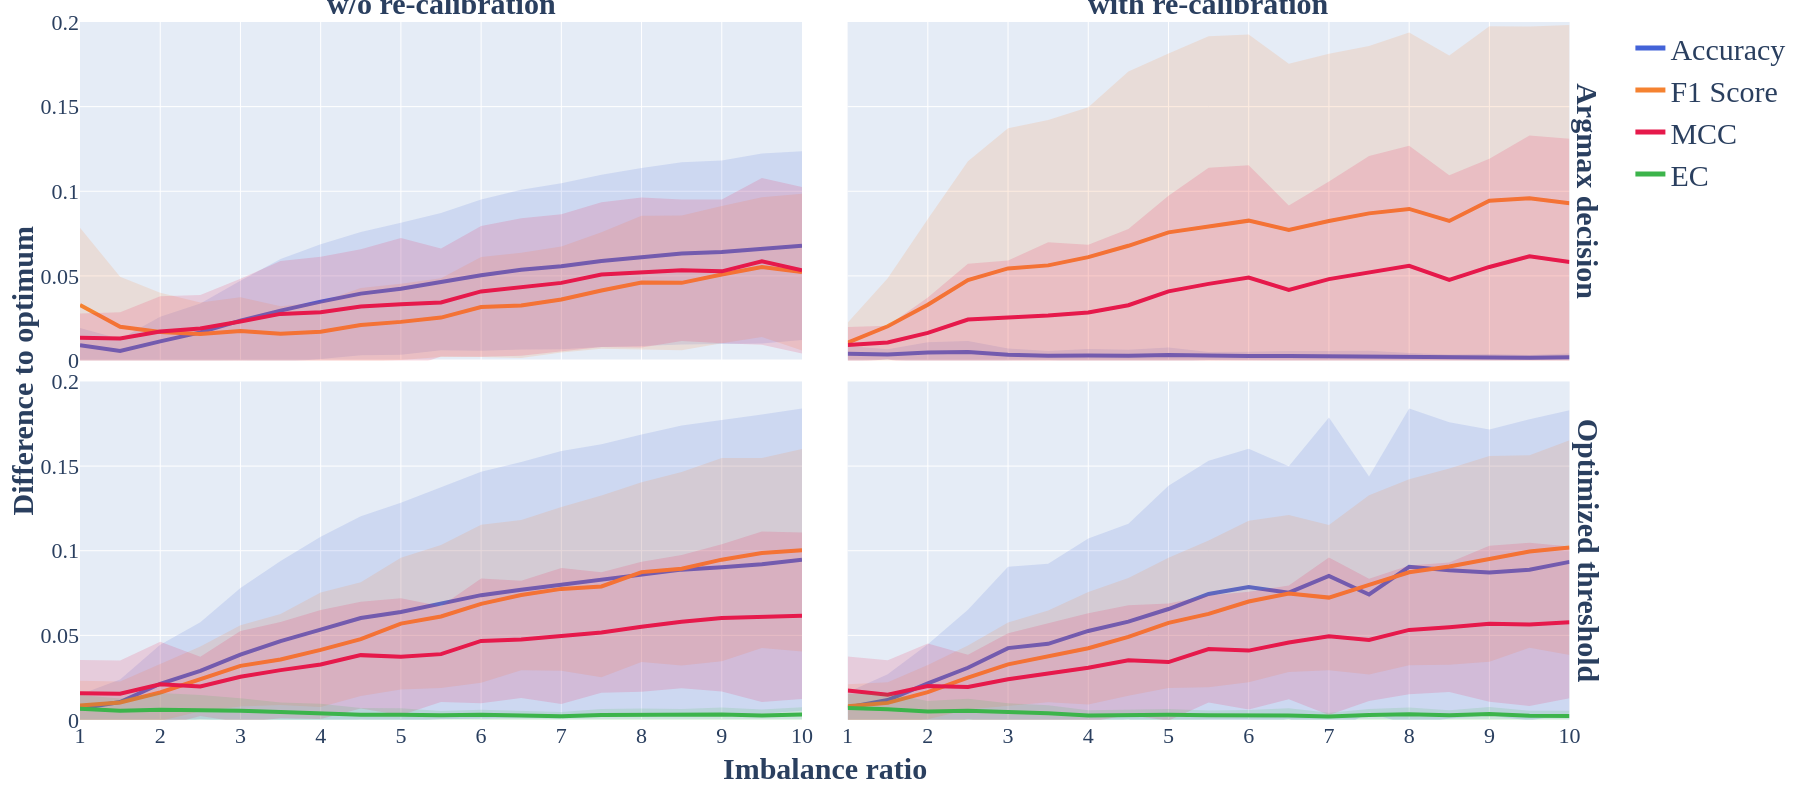

In [15]:
display.Image(RESULT_PATH / f"fig_4.png")

## Supplement plot

In [9]:
# initialize the supplement dataframe
sup_df = pd.DataFrame(binary_tasks, columns=['name'])

# define calibration and thresholding methods
cal = CalibrationMethod.AFFINE_ESTIMATED
thresholding = ThresholdingMethod.ARGMAX

# iterate over standard deviations for the non exact priors
for std in [0.05, 0.075, 0.1]:
    # load the appropriate results file
    result_df = pd.read_pickle(RESULT_PATH / ("exp_2_results_"+cal.value+"_"+thresholding.value+f"_std_{std}.pkl"))

    # add ec computed with estimated priors with the given std to the supplement dataframe
    sup_df[f"EC (est. prev.) std={std}"] = result_df[Metric.EC] - result_df['reference EC']

# load the exact priors data
cal = CalibrationMethod.AFFINE_REWEIGHTED
result_df = pd.read_pickle(RESULT_PATH / ("exp_2_results_"+cal.value+"_"+thresholding.value+f"_std_{std}.pkl"))

# add balanced accuracy and EC computed with deployment prevalences to supplement datafrane
sup_df[Metric.BALANCED_ACC.value] = result_df[Metric.BALANCED_ACC] - result_df['reference Bal. Accuracy']
sup_df[Metric.EC_ADJUSTED.value] = result_df[Metric.EC_ADJUSTED] - result_df['reference EC']

# create metrics list
metrics = [k for k in sup_df.keys() if k!="name"]
# create subplots
fig1 = plot_aggregate_results(sup_df, metrics=[Metric.BALANCED_ACC, Metric.EC_ADJUSTED], y_axis_title="Absolute difference to <br>metric score on D<sub>dev</sub> set", ci=Confidence.NONE)
fig2 = plot_aggregate_results(sup_df, metrics =['EC (est. prev.) std=0.05', 'EC (est. prev.) std=0.075', 'EC (est. prev.) std=0.1'], ci=Confidence.NONE)
# aggregate subplots in 1 figure
for i, value in enumerate(fig2['data']):
    value['showlegend']=True
    fig1.add_trace(value)
# compute metrics value at IR 10
ir_10_metrics = last_value_df(sup_df, [Metric.BALANCED_ACC, Metric.EC_ADJUSTED,'EC (est. prev.) std=0.05','EC (est. prev.) std=0.075','EC (est. prev.) std=0.1'], delta=False)
# plot sub box plots
box1 = box_plot(ir_10_metrics, metrics=[Metric.BALANCED_ACC, Metric.EC_ADJUSTED])
box2 = box_plot(ir_10_metrics, metrics =['EC (est. prev.) std=0.05', 'EC (est. prev.) std=0.075', 'EC (est. prev.) std=0.1'])
# aggregate box plots in 1 figure
for  value in box2['data']:
    value['showlegend']=True
    box1.add_trace(value)

In [10]:
# create the Fig. 8 from the supplement
fig = multiplot(rows=1, cols=2, subplts=[fig1, box1], horizontal_spacing=0.04, legend_index=1, 
y_title  = "<b>Difference to optimum</b>", sub_x_axis_titles={0: "Imbalance ratio"}, sub_y_ranges={0: [0, 0.1]}, shared_yaxes=False)

In [12]:
# save plots
name = "fig_8"
fig.write_image(RESULT_PATH / f"{name}.png")
fig.write_image(RESULT_PATH / f"{name}.pdf")
fig.write_html(RESULT_PATH / f"{name}.html")

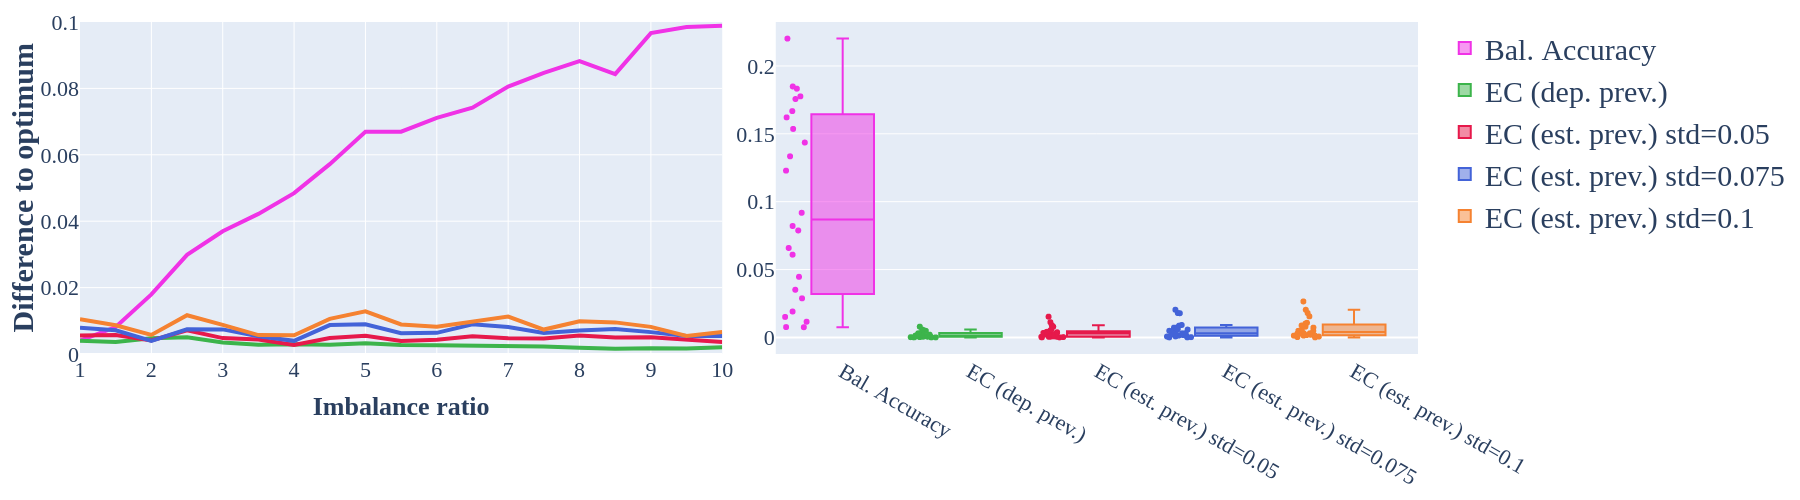

In [16]:
display.Image(RESULT_PATH / f"fig_8.png")